In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [51]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [52]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x
    return poten

In [53]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [54]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

La=0
Lb =400
L=Lb-La  # domain length
N = 2000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=2
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [55]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [56]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=100,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:4.400501728057861,time:0.054633140563964844,lr:0.01
epoch:10,loss:3.7153005599975586,time:0.5840959548950195,lr:0.01
epoch:20,loss:3.0768871307373047,time:1.113858699798584,lr:0.01
epoch:30,loss:2.1496236324310303,time:1.6483855247497559,lr:0.01
epoch:40,loss:1.6749074459075928,time:2.180213212966919,lr:0.01
epoch:50,loss:2.0179967880249023,time:2.712811231613159,lr:0.01
epoch:60,loss:1.4774658679962158,time:3.244935989379883,lr:0.01
epoch:70,loss:1.2993769645690918,time:3.779268264770508,lr:0.01
epoch:80,loss:1.0456898212432861,time:4.313563585281372,lr:0.01
epoch:90,loss:0.967301607131958,time:4.850018739700317,lr:0.01
epoch:100,loss:0.9876998662948608,time:5.3901307582855225,lr:0.01
epoch:110,loss:0.794317364692688,time:5.945446491241455,lr:0.01
epoch:120,loss:0.7021852731704712,time:6.494060039520264,lr:0.01
epoch:130,loss:0.5783135890960693,time:7.028717279434204,lr:0.01
epoch:140,loss:0.633332371711731,time:7.556461572647095,lr:0.01
epoch:150,loss:0.5855422019958496,

In [57]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

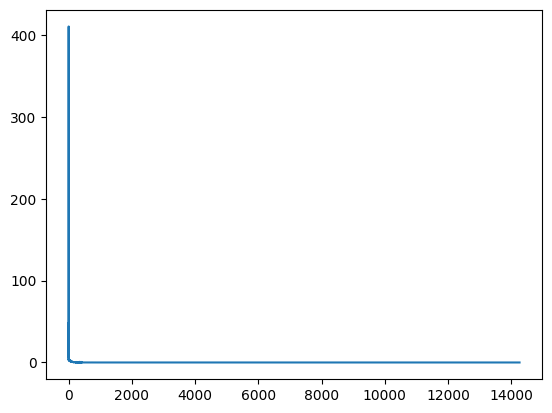

In [58]:
plt.plot(loss_list)
plt.show()

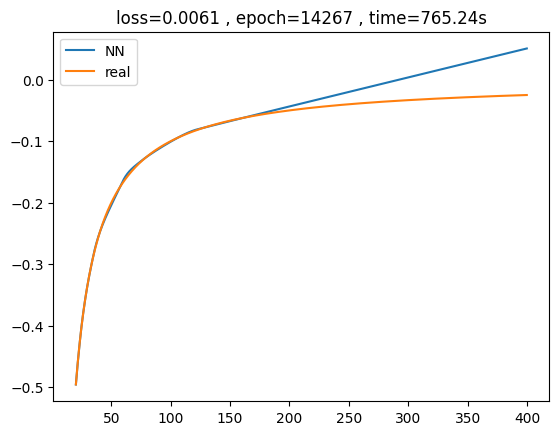

In [59]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


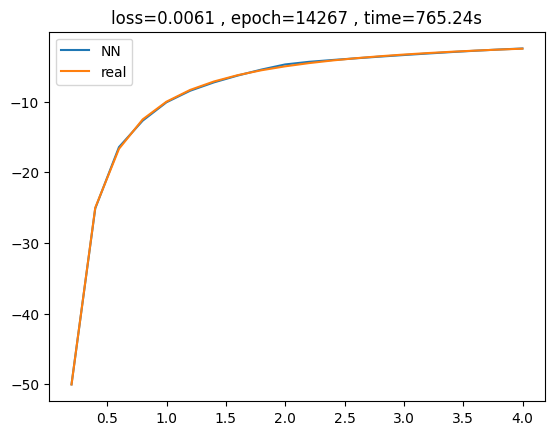

In [60]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:20]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [61]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

print('NN energy:')
print(output)
print('real energy:')
print(real_en_list[0])

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

NN energy:
tensor([-30.9102, -10.3567,  -5.0467,  -2.9510,  -1.8991,  -1.3503,  -1.0003,
         -0.7693,  -0.6092,  -0.4951,  -0.4100,  -0.3447,  -0.2942,  -0.2535,
         -0.2218,  -0.1962,  -0.1736,  -0.1533,  -0.1368,  -0.1242,  -0.1132,
         -0.1034,  -0.0946,  -0.0866,  -0.0796,  -0.0738,  -0.0687,  -0.0639,
         -0.0594,  -0.0551], device='cuda:2', grad_fn=<SliceBackward0>)
real energy:
tensor([-30.9102, -10.3569,  -5.0467,  -2.9510,  -1.9259,  -1.3524,  -1.0004,
         -0.7694,  -0.6099,  -0.4951,  -0.4099,  -0.3448,  -0.2941,  -0.2538,
         -0.2212,  -0.1946,  -0.1724,  -0.1538,  -0.1381,  -0.1247,  -0.1131,
         -0.1031,  -0.0943,  -0.0867,  -0.0799,  -0.0739,  -0.0685,  -0.0637,
         -0.0594,  -0.0555], device='cuda:2')
final error: tensor([-1.9073e-06,  1.4305e-04,  1.4305e-06, -4.5300e-06,  2.6807e-02,
         2.0452e-03,  1.2267e-04,  1.4150e-04,  6.1709e-04,  3.2216e-05,
        -1.1894e-04,  1.7053e-04, -5.6803e-05,  2.7758e-04, -6.0430e-04,
  

energy level while l=0


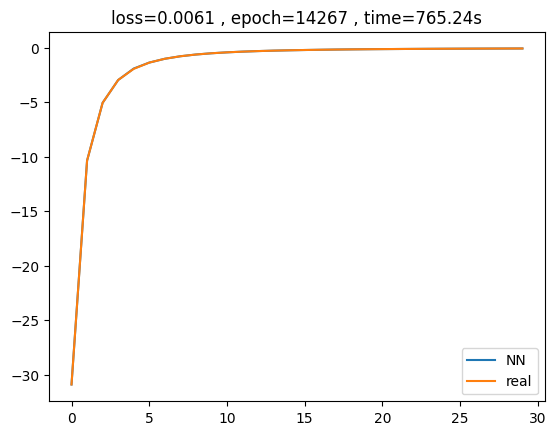

In [62]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

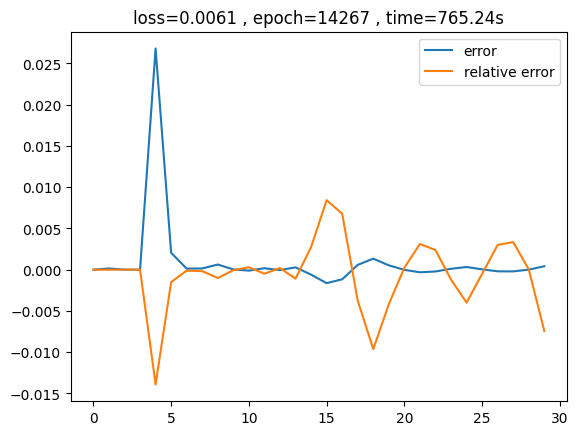

In [63]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()